# Train UNAGI model based on the PCLS data

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
from UNAGI import UNAGI
unagi = UNAGI()

unagi.setup_data('../data/pcls',total_stage=2,stage_key='stage')
unagi.setup_training(task='pcls',dist='zig',device='cuda:0',GPU=True,epoch_iter=10,epoch_initial=10,max_iter=5,BATCHSIZE=1024,lr_dis=1e-5,beta=1)
unagi.run_UNAGI(idrem_dir = 'PATH_TO_IDREM',CPO=False)

# Perform in-silico perturbation and visualize the predicted post-treatment gene expression 

R^2 score r^2: 0.902419188352781


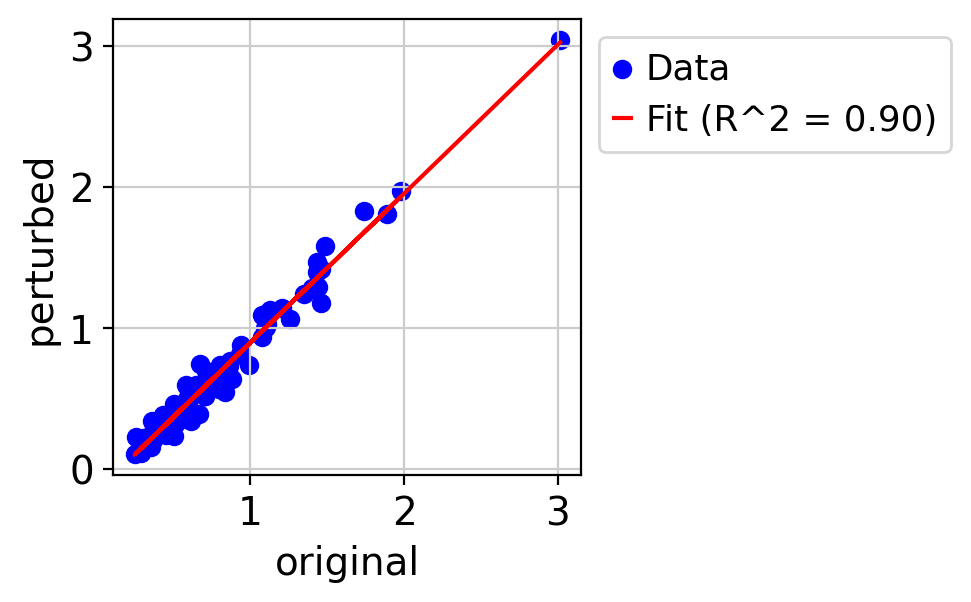

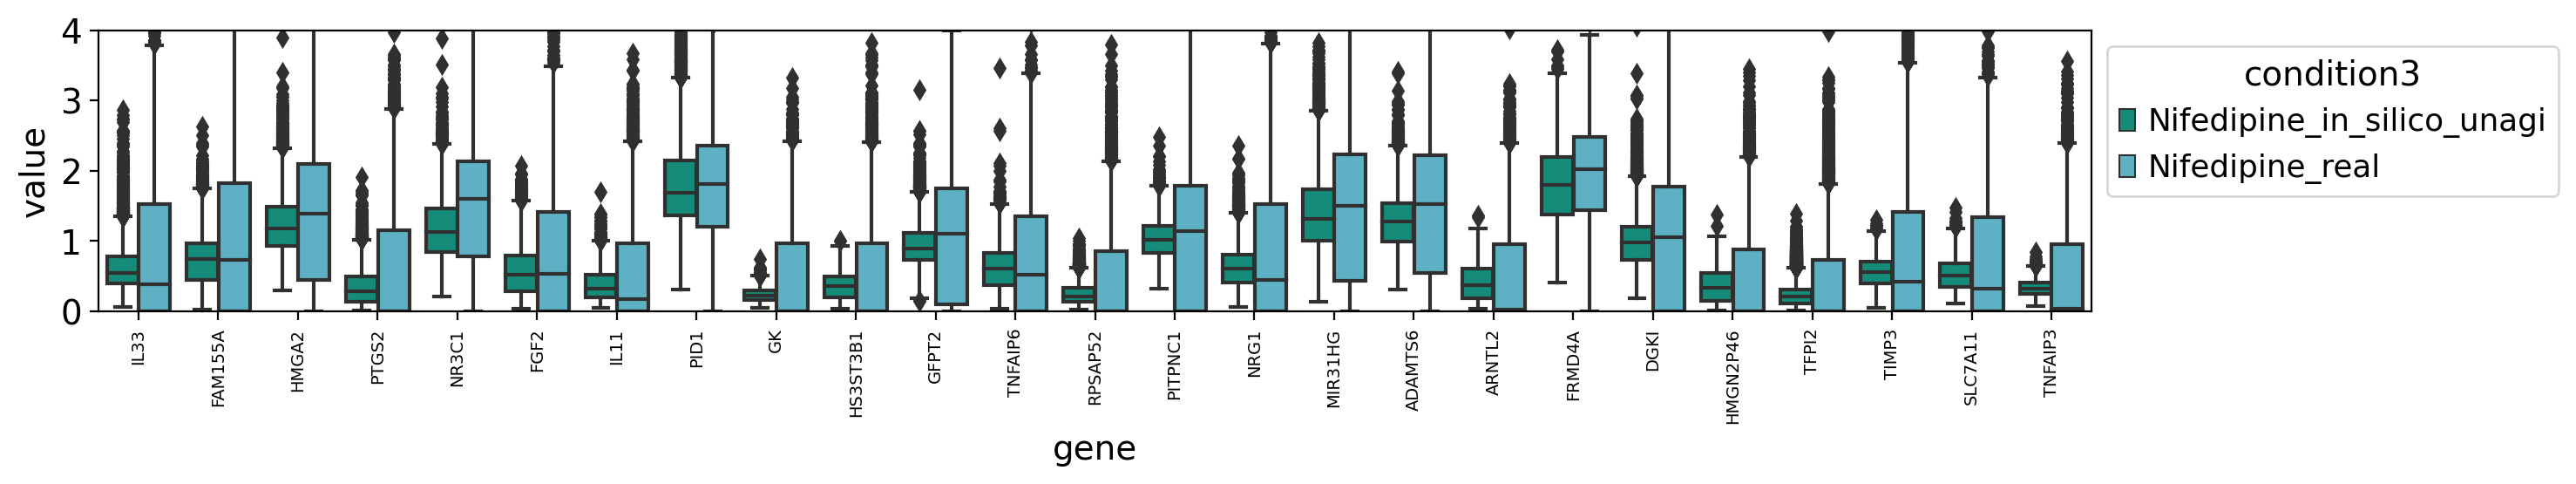

R^2 score r^2: 0.9717627898696471


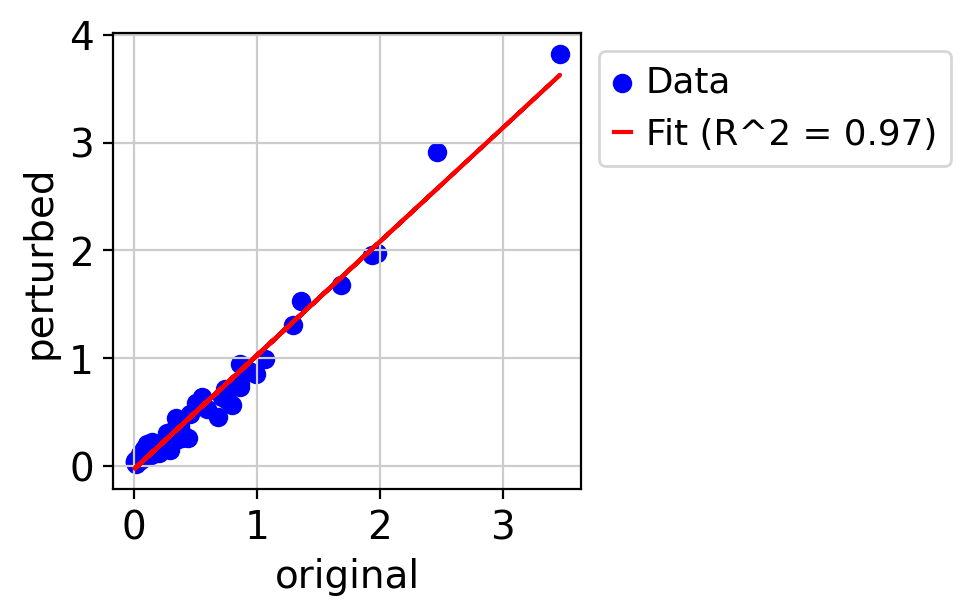

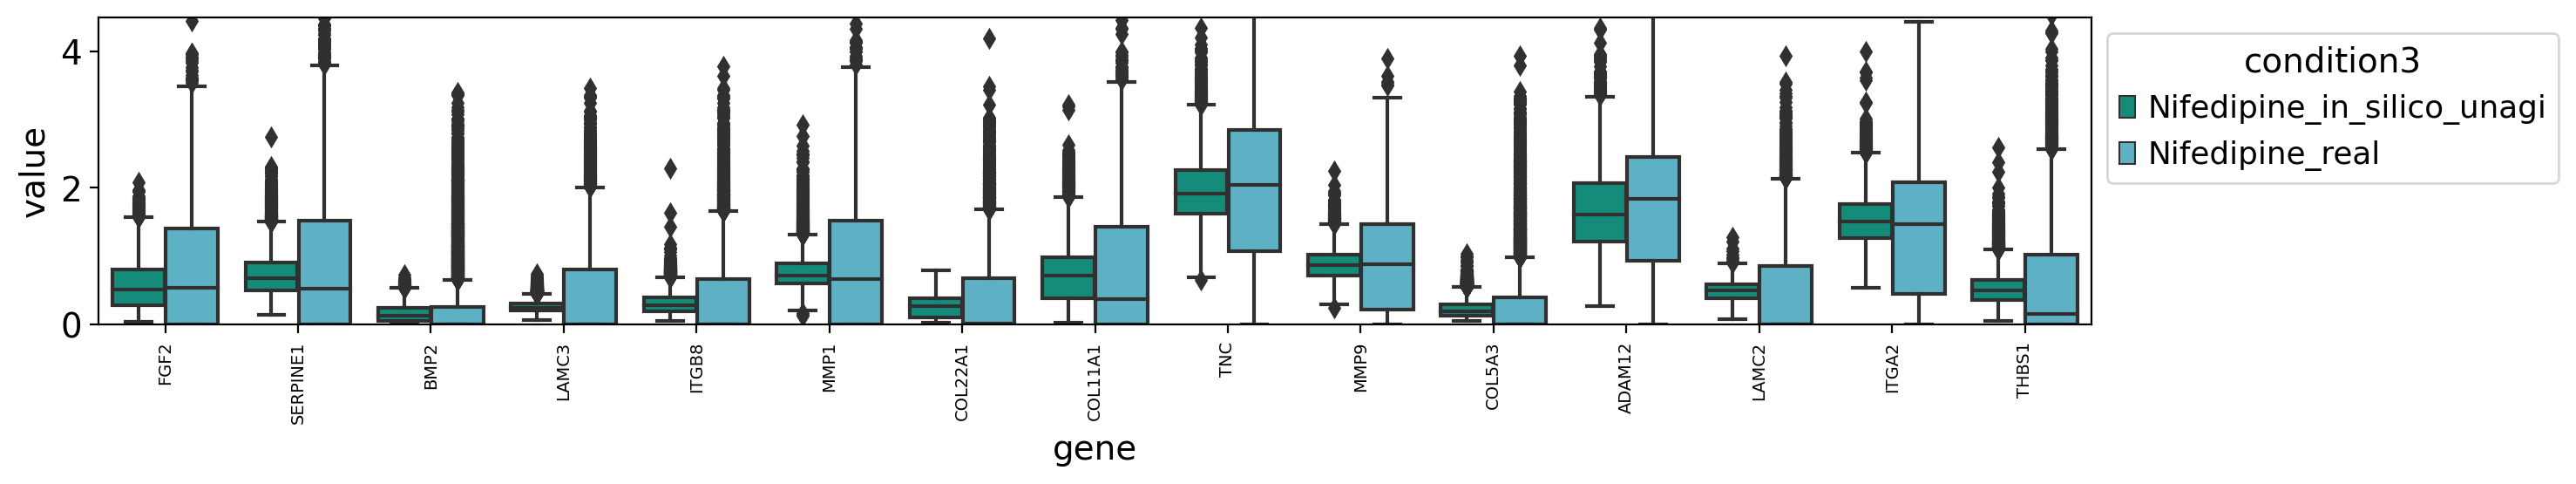

R^2 score r^2: 0.8909561190732186


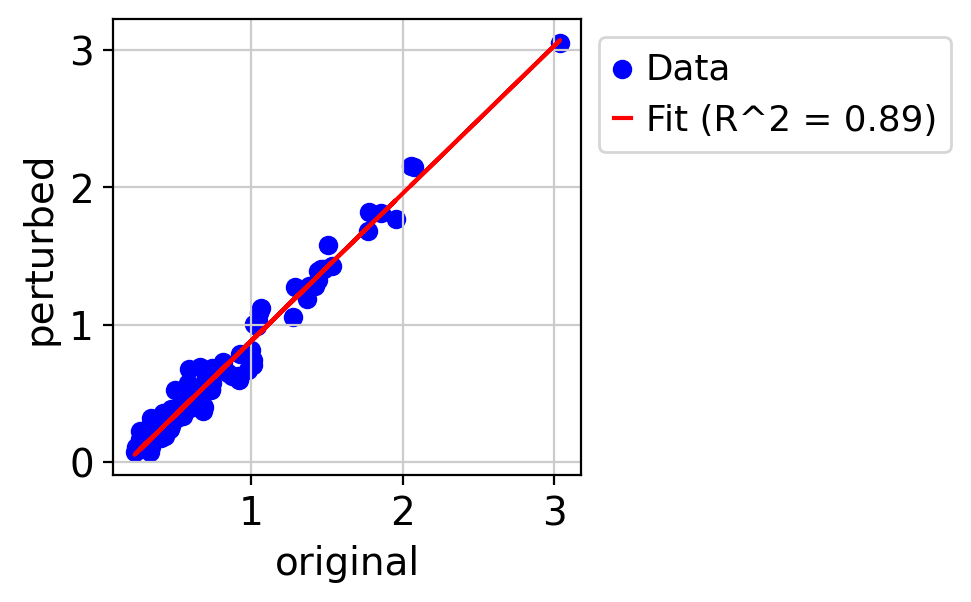

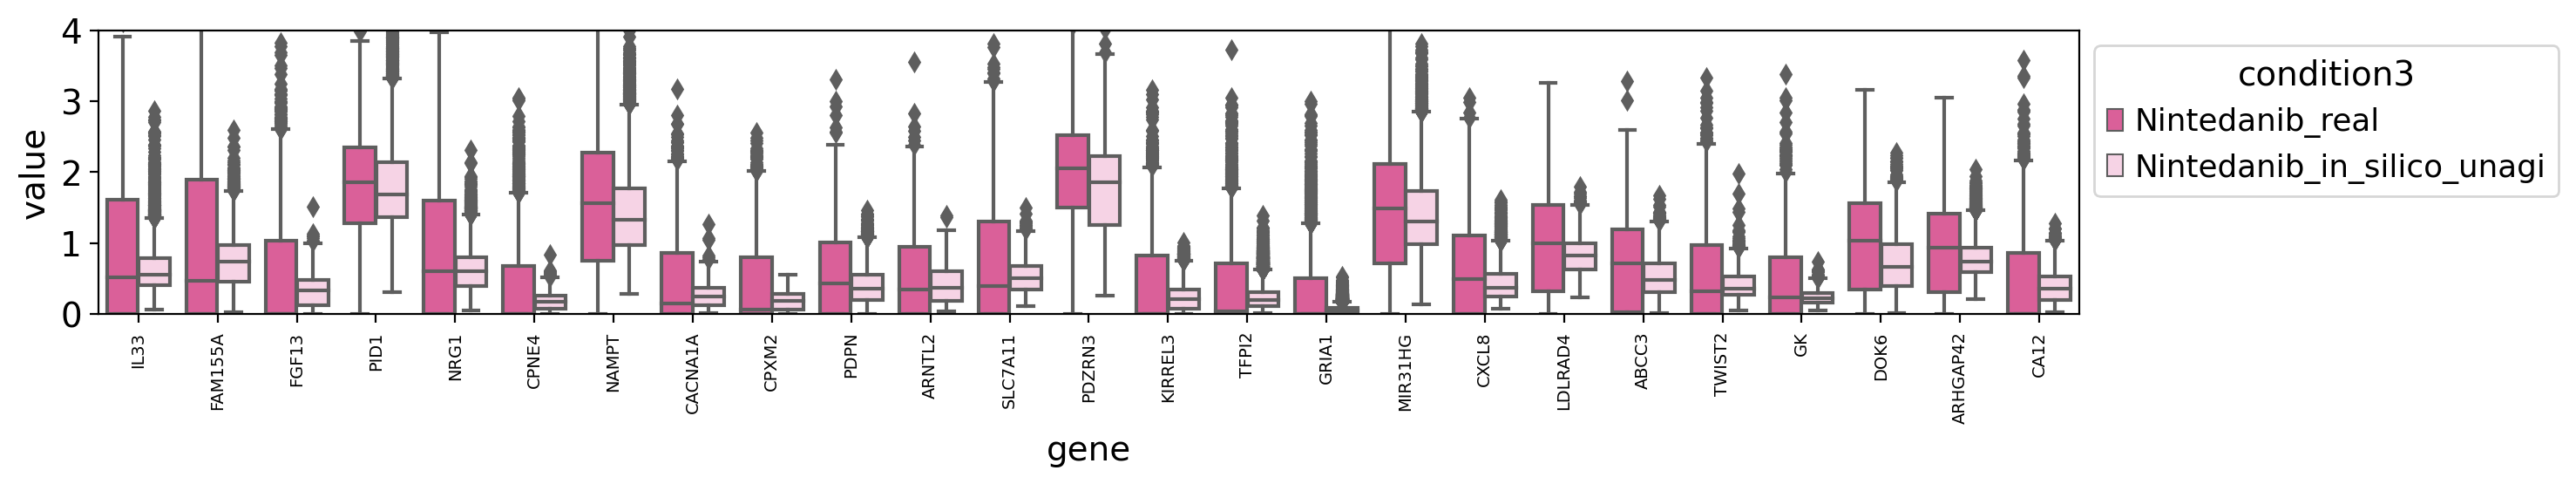

R^2 score r^2: 0.9653058084863206


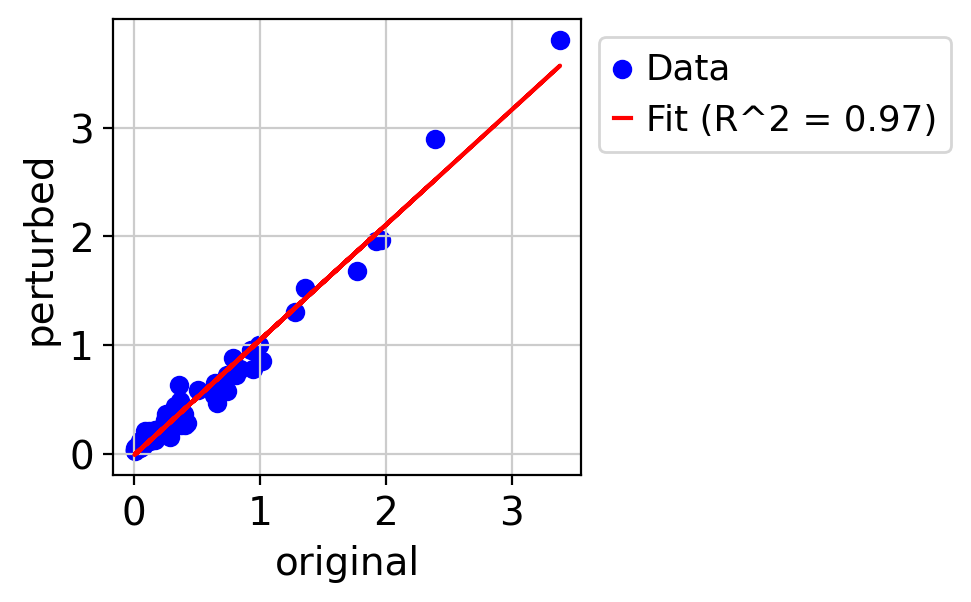

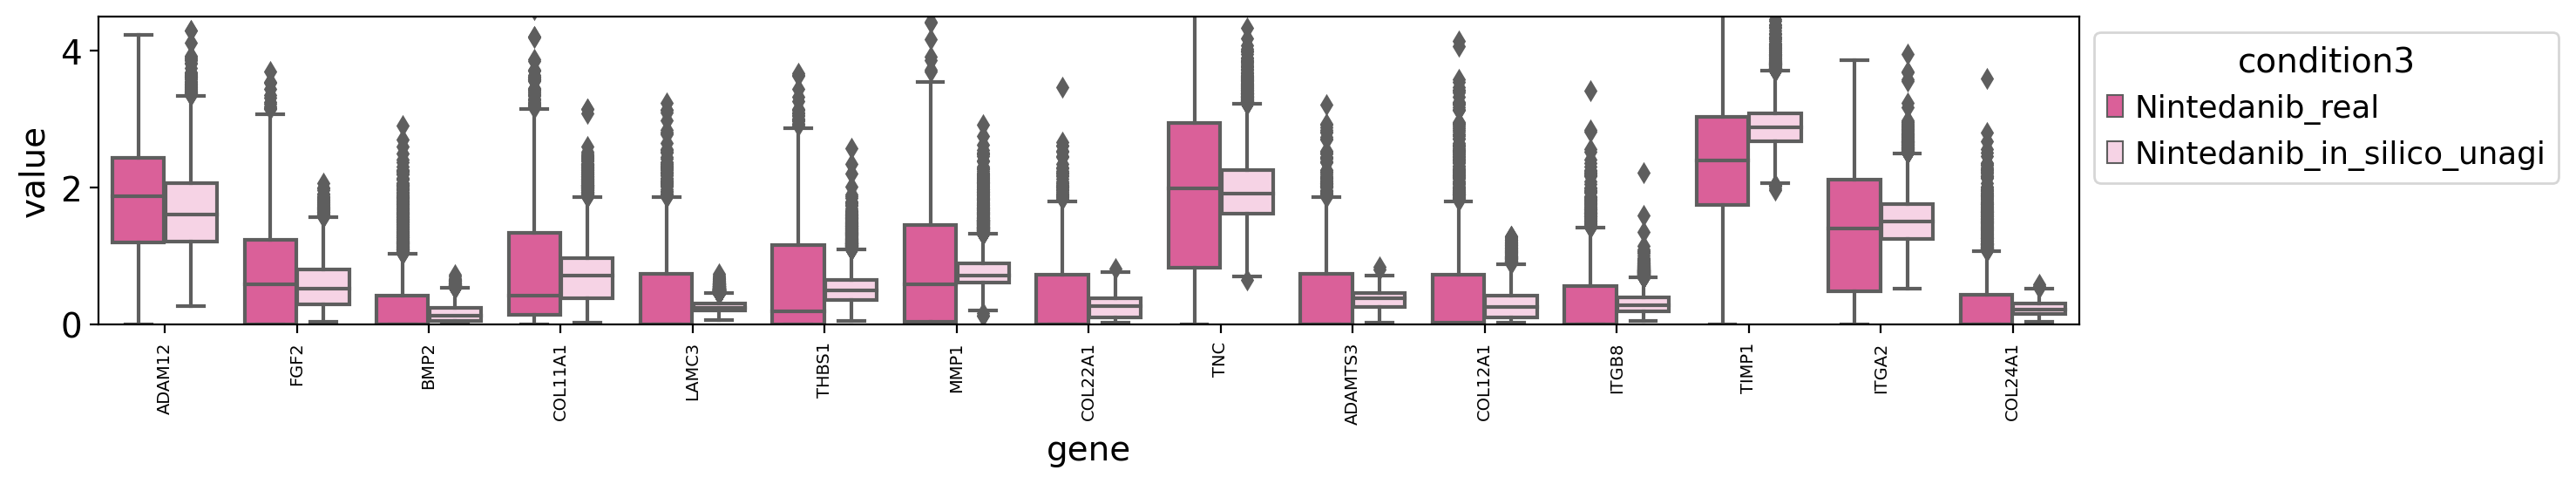

In [8]:
import numpy as np
import scanpy as sc
import torch
from UNAGI.model.models import VAE
from UNAGI.utils.gcn_utils import setup_graph
import anndata
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import r2_score
from scipy.stats import f_oneway, ks_2samp, mannwhitneyu, wilcoxon, ttest_ind,ranksums,wasserstein_distance,chisquare,pearsonr,energy_distance

def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def my_logfold_change(adata1, adata2,topN,log_fold_change_cutoff=None,abs = False):
    genenames = adata1.var_names.tolist()
    mean1 = np.mean(adata1.X.toarray(),axis=0)
    mean2 = np.mean(adata2.X.toarray(),axis=0)
    logfold_change = mean2 - mean1
    logfold_change_dict = {}

    for i, each in enumerate(genenames):
        logfold_change_dict[each] = logfold_change[i]
    if abs ==True:
        temp = {k: v for k, v in sorted(logfold_change_dict.items(), key=lambda item: np.abs(item[1]),reverse=True)}
    else:
        temp = {k: v for k, v in sorted(logfold_change_dict.items(), key=lambda item: item[1],reverse=True)}

    df = pd.DataFrame()
    df['logfoldchange'] = temp.values()
    df['genes'] = temp.keys()
    if log_fold_change_cutoff is not None:
        df = df[np.abs(df['logfoldchange'])>log_fold_change_cutoff]
    topDEG = list(df[:topN]['genes'].values)
    return topDEG,df
def calculate_r_squared(y_true, y_pred):
    ssr = np.sum((y_true - y_pred) ** 2)
    sst = np.sum((y_true - np.mean(y_true)) ** 2)
    r_squared = 1 - (ssr / sst)
    return r_squared
def calculate_adjusted_r_squared(r_squared, n, k):
    adjusted_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - k - 1))
    return adjusted_r_squared
sc.set_figure_params(dpi_save=300,figsize=[20,3])
def cosine_similarity(v1, v2):
    # Compute the dot product of v1 and v2
    dot_product = np.dot(v1, v2)
    # Compute the L2 norm of v1
    norm_v1 = np.linalg.norm(v1)
    # Compute the L2 norm of v2
    norm_v2 = np.linalg.norm(v2)
    # Compute cosine similarity
    similarity = dot_product / (norm_v1 * norm_v2)
    return similarity
def adjusted_r2(r2, n, k):
    """
    Calculate the adjusted R-squared.
    
    Parameters:
    - r2: The regular R-squared value
    - n: The number of observations
    - k: The number of predictors (excluding the intercept)
    
    Returns:
    - The adjusted R-squared value
    """
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Example usage:
def draw_real_recons_heatmap(adata, adata1, adata2, genes,gorupby, enmax_palette, ymax, topN=20,use_zero=False,save_fig = False,cut = False,similarity=False):
    temp = []
    pval = []
    for idx, each in enumerate(genes):
        if cut:
            
            if np.median(adata1[:,each].X.toarray()) <1:
                temp.append(0)
                pval.append(0)
                continue
            else:
                pass
        obs_nif = adata1[:,each].X.toarray().flatten()
        obs_nif_perturbed = adata2[:,each].X.toarray().flatten()
        obs_nif_perturbed[obs_nif_perturbed<0] = 0
        if len(obs_nif_perturbed[obs_nif_perturbed>0]) == 0:
            obs_nif_perturbed = np.array([0.00000001,0.0000001])

        if use_zero:
            pair1 = energy_distance(obs_nif_perturbed,obs_nif)
        else:
            pair1 = ks_2samp(obs_nif_perturbed[obs_nif_perturbed>0],obs_nif[obs_nif>0],alternative='two-sided')[1]
            pval.append(ks_2samp(obs_nif_perturbed[obs_nif_perturbed>0],obs_nif[obs_nif>0],alternative='two-sided')[1])
        temp.append(pair1)  
  
    protencoding = [each for each in genes if 'AC' != each[:2] and 'AL' != each[:2] and 'AP' != each[:2] and 'LINC' != each[:4] ]

    if similarity == False:
        df = sc.get.obs_df(adata, list(np.array(protencoding)[:topN])+['condition3'])
    else:
        df = sc.get.obs_df(adata, list(np.array(genes)[np.argsort(temp)[::-1]][:topN])+['condition3'])
    custom_dict = {}
    for i ,each in  enumerate(list(np.array(genes)[np.argsort(temp)[::-1]][:topN])):
        custom_dict[each] = i
    df = df.set_index('condition3').stack().reset_index()
    
    df.columns = ['condition3', 'gene', 'value']
    df.sort_values(by=['gene'], key=lambda x: x.map(custom_dict))

    original_mean =  np.mean(np.array(adata1[:,np.array(genes)[np.argsort(temp)[::-1]]].X.toarray()),axis=0)
    perturbed_mean = np.mean(np.array(adata2[:,np.array(genes)[np.argsort(temp)[::-1]]].X.toarray()),axis=0)

    # Generate some sample data
    np.random.seed(0)
    x = original_mean
    y = perturbed_mean
    # plt.scatter(x, y)
    # plt.scatter(x,x)
    # plt.show()

    # Perform linear regression
    rsquare = calculate_r_squared(x,y)
    print('R^2 score r^2:',r2_score(x,y))
    slope, intercept, r_value, p_value, std_err = linregress(x, y,alternative='greater')
    # Create scatter plot and plot regression line
    fig,ax = plt.subplots(figsize=(3,3),dpi=100)
    ax.scatter(x, y, label='Data', color='blue')
    ax.plot(x, slope * x + intercept, label=f'Fit (R^2 = {rsquare:.2f})', color='red')
    ax.legend(bbox_to_anchor=(1, 1))
    # ax.grid(False)
    plt.xlabel('original')
    plt.ylabel('perturbed')
    if save_fig != False:
        plt.savefig('R^2'+save_fig,dpi=300)

    if save_fig == False:
        
        fig,ax = plt.subplots(figsize=(15,3),dpi=100)
        sns.boxplot(data=df, x='gene', y='value', hue='condition3', palette=enmax_palette)
        ax.grid(False)
        for item in ax.get_xticklabels():
            item.set_rotation(90)
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        ax.tick_params(axis='x', which='major', labelsize=7)
        plt.ylim(0,ymax)
        plt.tight_layout()
        plt.show()
    else:
        fig,ax = plt.subplots(figsize=(6,3),dpi=100)
        sns.boxplot(data=df, x='gene', y='value', hue='condition3', palette=enmax_palette)
        # sns.violinplot(data=df, x='gene', y='value', hue='condition3', split=True, palette=enmax_palette,scale='area')
        ax.grid(False)
        
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),fontsize=7)

        #rotate xticklabels 90 degree
        for item in ax.get_xticklabels():
            item.set_rotation(90)
       
        ax.tick_params(axis='x', which='major', labelsize=7)
        plt.ylim(0,ymax)
        #squize the figure
        plt.tight_layout()
        # plt.savefig(save_fig,dpi=300)
        plt.show()
def rankgene_logfold_change(adata1, adata2,gene_list,topN=False,abs = False):
    genenames = adata1.var_names.tolist()
    mean1 = np.mean(adata1.X.toarray(),axis=0)
    mean2 = np.mean(adata2.X.toarray(),axis=0)
    logfold_change = mean2 - mean1
    logfold_change_dict = {}

    for i, each in enumerate(genenames):
        logfold_change_dict[each] = logfold_change[i]
    if abs ==True:
        temp = {k: v for k, v in sorted(logfold_change_dict.items(), key=lambda item: np.abs(item[1]),reverse=True)}
    else:
        temp = {k: v for k, v in sorted(logfold_change_dict.items(), key=lambda item: item[1],reverse=True)}


    df = pd.DataFrame()
    df['logfoldchange'] = temp.values()
    df['genes'] = temp.keys()
    ranked_gene_list = []
    for each in temp.keys():
        if each in gene_list:
            ranked_gene_list.append(each)
    if topN:
        return ranked_gene_list[:topN]
    return ranked_gene_list

import seaborn as sns
vae = VAE(1993, 256,1024, 64,beta=1,distribution='zig')
vae.load_state_dict(torch.load('../data/pcls/model_save/test_pcls_4.pth',map_location='cuda:0'))
adata0 = sc.read('../data/pcls/0.h5ad')
adata1 = sc.read('../data/pcls/1.h5ad')
nintedanib = sc.read('../data/pcls/nintedanib.h5ad')
nifedipine = sc.read('../data/pcls/nifedipine.h5ad')


control_mean = np.array(adata0[adata0.obs['condition'] == 'Control'].X.mean(axis=0))[0]
ipf_mean = np.array(adata1[adata1.obs['condition'] == 'Fibrotic_Cocktail'].X.mean(axis=0))[0]
nin_mean = np.array(nintedanib.X.mean(axis=0))[0]
nif_mean = np.array(nifedipine.X.mean(axis=0))[0]
diff_nin = nin_mean - ipf_mean
diff_nif = nif_mean - ipf_mean
fib_nintedanib = adata1.copy()
fib_nifedipine = adata1.copy()
temp_diff = np.zeros_like(diff_nin)

inser_order = np.argsort(diff_nin)[::-1][:10]# perturb the top 10 treatment markers
temp_diff[inser_order] = diff_nin[inser_order]
diff_nin = temp_diff
temp_diff = np.zeros_like(diff_nif)
inser_order = np.argsort(diff_nif)[::-1][:10]# perturb the top 10 treatment markers
temp_diff[inser_order] = diff_nif[inser_order]
diff_nif = temp_diff

fib_nintedanib.X = fib_nintedanib.X + diff_nin
fib_nifedipine.X = fib_nifedipine.X + diff_nif
vae.eval()
adj = fib_nintedanib.obsp['gcn_connectivities'].asformat('coo')
adj = setup_graph(adj)
data = torch.tensor(np.array(fib_nintedanib.X))
data = data.to('cuda:0')
adj = adj.to('cuda:0')
vae = vae.to('cuda:0')
with torch.no_grad():
    reconst = vae.generate(data, adj)
pred_nin = sc.AnnData(X=reconst.cpu().numpy(),obs=fib_nintedanib.obs,var=fib_nintedanib.var)
pred_nin.obs['condition3'] = 'insilico_nintedanib'
vae.eval()
adj = fib_nifedipine.obsp['gcn_connectivities'].asformat('coo')
adj = setup_graph(adj)
data = torch.tensor(np.array(fib_nifedipine.X))
data = data.to('cuda:0')
adj = adj.to('cuda:0')
vae = vae.to('cuda:0')
with torch.no_grad():
    reconst = vae.generate(data, adj)
pred_nif = sc.AnnData(X=reconst.cpu().numpy(),obs=fib_nifedipine.obs,var=fib_nifedipine.var)
pred_nif.obs['condition3'] = 'insilico_nifedipine'
enmax_palette = sns.color_palette(["#00A087",  "#4DBBD5"])
nifedipine.obs['condition3'] = 'Nifedipine_real'
pred_nif.obs['condition3'] = 'Nifedipine_in_silico_unagi'
nif = [pred_nif,nifedipine]
nif = anndata.concat(nif)
test_gene,df= my_logfold_change(adata1, nifedipine,100)
draw_real_recons_heatmap(nif, nifedipine, pred_nif, test_gene,'condition3',enmax_palette, ymax=4, topN=25,use_zero=False,cut=True)

ecm_genes = ['MUSK', 'TLL1', 'VCAN', 'CDH1', 'TNC', 'LTBP1', 'ELN', 'LAMC3', 'COL23A1', 'LAMA3', 'LAMC2', 'COL11A1', 'COL17A1', 'NTN4', 'FBLN1', 'ITGA8', 'COL5A3', 'COL4A4', 'CEACAM6', 'ICAM1', 'P3H2', 'LAMB1', 'ITGA6', 'TGFB2', 'MMP11', 'MMP9', 'TIMP1', 'COMP', 'ITGB8', 'SERPINE1', 'ICAM2', 'COL1A1', 'VWF', 'COL12A1', 'SPARC', 'COL7A1', 'ITGB6', 'FN1', 'TNR', 'SPP1', 'LTBP2', 'MMP19', 'COL10A1', 'SDC4', 'COL21A1', 'BMP2', 'KDR', 'COL5A1', 'MATN3', 'COL4A2', 'ADAMTS8', 'CAPN9', 'CTSV', 'MMP7', 'THBS1', 'ITGA11', 'LOXL4', 'ADAMTS14', 'FGF2', 'FBN2', 'LUM', 'ADAMTS18', 'ITGA9', 'COL8A1', 'ADAMTS16', 'HAPLN1', 'ADAM12', 'NCAM1', 'PLOD2', 'ADAMTS5', 'MMP16', 'ADAMTS3', 'ACAN', 'VCAM1', 'CAPN13', 'COL6A3', 'ADAMTS9', 'ITGA2', 'COL1A2', 'FBN1', 'MMP10', 'BMP1', 'COL3A1', 'COL4A3', 'COL22A1', 'COL24A1', 'FGG', 'FGA', 'NRXN1', 'BGN', 'COL4A1', 'COL14A1', 'COL25A1', 'SPOCK3', 'LAMA2', 'MMP1', 'COL27A1', 'LAMB3', 'COL4A6', 'MFAP5', 'DMD', 'CAPN8', 'COL5A2', 'COL15A1', 'COL6A6', 'ITGA1', 'COL28A1']
ecm_genes = sorted(list(set(nifedipine.var_names.tolist() ) & set(ecm_genes)))
ecm_genes = rankgene_logfold_change(adata1, nifedipine,ecm_genes,abs=True)

draw_real_recons_heatmap(nif, nifedipine, pred_nif, ecm_genes,'condition3',enmax_palette,ymax=4.5,topN=15,use_zero=False)
pred_nin.obs['condition3'] = 'Nintedanib_in_silico_unagi'
nintedanib.obs['condition3'] = 'Nintedanib_real'
nin = [nintedanib,pred_nin]
enmax_palette = sns.color_palette(["#EE4C97","#fccde5"])
nin = anndata.concat(nin)
test_gene,df = my_logfold_change(adata1, nintedanib,100)
draw_real_recons_heatmap(nin, nintedanib, pred_nin, test_gene,'condition3',enmax_palette,ymax=4, topN=25,use_zero=False,similarity=False,cut=True)
enmax_palette = sns.color_palette(["#EE4C97",  "#fccde5"])
nin = anndata.concat(nin)
ecm_genes = rankgene_logfold_change(adata1, nintedanib,ecm_genes,abs=True)
draw_real_recons_heatmap(nin, nintedanib, pred_nin, ecm_genes,'condition3',enmax_palette,ymax=4.5,topN=15,similarity=False,use_zero=False)


# Perform the in-silico perturbation and calcualte pearson correlation of predicted gene expression changes

In [1]:
import numpy as np
import scanpy as sc
import torch
from UNAGI.model.models import VAE
from UNAGI.utils.gcn_utils import setup_graph

import anndata
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import f_oneway, ks_2samp, mannwhitneyu, wilcoxon, ttest_ind,ranksums,wasserstein_distance,chisquare,pearsonr,energy_distance
from scipy.stats import linregress
from sklearn.metrics import r2_score
def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def my_logfold_change(adata1, adata2,topN,log_fold_change_cutoff=None,abs = False):
    genenames = adata1.var_names.tolist()
    mean1 = np.mean(adata1.X.toarray(),axis=0)
    mean2 = np.mean(adata2.X.toarray(),axis=0)
    logfold_change = mean2 - mean1
    logfold_change_dict = {}

    for i, each in enumerate(genenames):
        logfold_change_dict[each] = logfold_change[i]
    if abs ==True:
        temp = {k: v for k, v in sorted(logfold_change_dict.items(), key=lambda item: np.abs(item[1]),reverse=True)}
    else:
        temp = {k: v for k, v in sorted(logfold_change_dict.items(), key=lambda item: item[1],reverse=True)}

    df = pd.DataFrame()
    df['logfoldchange'] = temp.values()
    df['genes'] = temp.keys()
    if log_fold_change_cutoff is not None:
        df = df[np.abs(df['logfoldchange'])>log_fold_change_cutoff]
    topDEG = list(df[:topN]['genes'].values)
    return topDEG,df
def calculate_r_squared(y_true, y_pred):
    ssr = np.sum((y_true - y_pred) ** 2)
    sst = np.sum((y_true - np.mean(y_true)) ** 2)
    r_squared = 1 - (ssr / sst)
    return r_squared
def calculate_adjusted_r_squared(r_squared, n, k):
    adjusted_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - k - 1))
    return adjusted_r_squared
sc.set_figure_params(dpi_save=300,figsize=[20,3])
def cosine_similarity(v1, v2):
    # Compute the dot product of v1 and v2
    dot_product = np.dot(v1, v2)
    # Compute the L2 norm of v1
    norm_v1 = np.linalg.norm(v1)
    # Compute the L2 norm of v2
    norm_v2 = np.linalg.norm(v2)
    # Compute cosine similarity
    similarity = dot_product / (norm_v1 * norm_v2)
    return similarity
def adjusted_r2(r2, n, k):
    """
    Calculate the adjusted R-squared.
    
    Parameters:
    - r2: The regular R-squared value
    - n: The number of observations
    - k: The number of predictors (excluding the intercept)
    
    Returns:
    - The adjusted R-squared value
    """
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Example usage:
def  calculate_pearsonr_post_treatment_prediction(control, adata, adata1, adata2, genes):
    original_median=  np.median(np.array(adata1[:,np.array(genes)].X.toarray()),axis=0)
    perturbed_median = np.median(np.array(adata2[:,np.array(genes)].X.toarray()),axis=0)
    control_median = np.median(np.array(control[:,np.array(genes)].X.toarray()),axis=0)
    #calculate pearson correlation between original and perturbed
    original_median = original_median-control_median
    perturbed_median = perturbed_median-control_median

    print('pearsonr correlation:',pearsonr(original_median,perturbed_median))

def rankgene_logfold_change(adata1, adata2,gene_list,topN=False,abs = False):
    genenames = adata1.var_names.tolist()
    mean1 = np.mean(adata1.X.toarray(),axis=0)
    mean2 = np.mean(adata2.X.toarray(),axis=0)
    logfold_change = mean2 - mean1
    logfold_change_dict = {}

    for i, each in enumerate(genenames):
        logfold_change_dict[each] = logfold_change[i]
    if abs ==True:
        temp = {k: v for k, v in sorted(logfold_change_dict.items(), key=lambda item: np.abs(item[1]),reverse=True)}
    else:
        temp = {k: v for k, v in sorted(logfold_change_dict.items(), key=lambda item: item[1],reverse=True)}


    df = pd.DataFrame()
    df['logfoldchange'] = temp.values()
    df['genes'] = temp.keys()
    ranked_gene_list = []
    for each in temp.keys():
        if each in gene_list:
            ranked_gene_list.append(each)
    if topN:
        return ranked_gene_list[:topN]
    return ranked_gene_list
import seaborn as sns
from scipy.stats import pearsonr
vae = VAE(1993, 256,1024, 64,beta=1,distribution='zig')
vae.load_state_dict(torch.load('PATH_TO_MODEL',map_location='cuda:0'))

adata0 = sc.read('../data/pcls/0.h5ad')
adata1 = sc.read('../data/pcls/1.h5ad')
nintedanib = sc.read('../data/pcls/nintedanib.h5ad')
nifedipine = sc.read('../data/pcls/nifedipine.h5ad')

control_mean = np.array(adata0[adata0.obs['condition'] == 'Control'].X.mean(axis=0))[0]
ipf_mean = np.array(adata1[adata1.obs['condition'] == 'Fibrotic_Cocktail'].X.mean(axis=0))[0]
nin_mean = np.array(nintedanib.X.mean(axis=0))[0]
nif_mean = np.array(nifedipine.X.mean(axis=0))[0]
diff_nin = nin_mean - ipf_mean
diff_nif = nif_mean - ipf_mean
fib_nintedanib = adata1.copy()
fib_nifedipine = adata1.copy()
temp_diff = np.zeros_like(diff_nin)

inser_order = np.argsort(np.abs(diff_nin))[::-1][:10]#np.argsort(np.array(np.mean(temp_weight,axis=0))[0])[::-1][:10]
temp_diff[inser_order] = diff_nin[inser_order]
diff_nin = temp_diff
temp_diff = np.zeros_like(diff_nif)
inser_order = np.argsort(np.abs(diff_nif))[::-1][:10]#np.argsort(np.array(np.mean(temp_weight,axis=0))[0])[::-1][:10]
temp_diff[inser_order] = diff_nif[inser_order]
diff_nif = temp_diff

fib_nintedanib.X = fib_nintedanib.X + diff_nin
fib_nifedipine.X = fib_nifedipine.X + diff_nif
vae.eval()
adj = fib_nintedanib.obsp['gcn_connectivities'].asformat('coo')
adj = setup_graph(adj)
data = torch.tensor(np.array(fib_nintedanib.X))
data = data.to('cuda:1')
adj = adj.to('cuda:1')
vae = vae.to('cuda:1')
with torch.no_grad():
    reconst = vae.generate(data, adj)
pred_nin = sc.AnnData(X=reconst.cpu().numpy(),obs=fib_nintedanib.obs,var=fib_nintedanib.var)
pred_nin.obs['condition3'] = 'insilico_nintedanib'
vae.eval()
adj = fib_nifedipine.obsp['gcn_connectivities'].asformat('coo')
adj = setup_graph(adj)
data = torch.tensor(np.array(fib_nifedipine.X))
data = data.to('cuda:1')
adj = adj.to('cuda:1')
vae = vae.to('cuda:1')
with torch.no_grad():
    reconst = vae.generate(data, adj)
pred_nif = sc.AnnData(X=reconst.cpu().numpy(),obs=fib_nifedipine.obs,var=fib_nifedipine.var)
nifedipine.obs['condition3'] = 'Nifedipine_real'
pred_nif.obs['condition3'] = 'Nifedipine_in_silico_unagi'
temp_nifedipine = nifedipine.copy()
temp_nifedipine.X = temp_nifedipine.X - np.mean(adata1.X.toarray(),axis=0)
temp_pred_nif = pred_nif.copy()
temp_pred_nif.X = temp_pred_nif.X - np.mean(adata1.X.toarray(),axis=0)
nif = [temp_pred_nif,temp_nifedipine]
nif = anndata.concat(nif)
top100_nif_treatment_markers,df= my_logfold_change(adata1, nifedipine,100)
calculate_pearsonr_post_treatment_prediction(adata1,nif, nifedipine, pred_nif, top100_nif_treatment_markers)

pred_nin.obs['condition3'] = 'Nintedanib_in_silico_unagi'
nintedanib.obs['condition3'] = 'Nintedanib_real'
temp_nintedanib = nintedanib.copy()
temp_nintedanib.X = temp_nintedanib.X - np.mean(adata1.X.toarray(),axis=0)
temp_pred_nin = pred_nin.copy()
temp_pred_nin.X = temp_pred_nin.X - np.mean(adata1.X.toarray(),axis=0)
nin = [temp_nintedanib,temp_pred_nin]
nin = anndata.concat(nin)
top100_nin_treatment_markers,df = my_logfold_change(adata1, nintedanib,100)
calculate_pearsonr_post_treatment_prediction(adata1,nin, nintedanib, pred_nin, top100_nin_treatment_markers)

pearsonr correlation: PearsonRResult(statistic=0.7558337080429267, pvalue=9.997165252304838e-20)
pearsonr correlation: PearsonRResult(statistic=0.825826045252644, pvalue=4.036602184862681e-26)
